In [76]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns 

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from glob import glob
import os, random, time, gc, warnings

from tqdm import tqdm_notebook

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score

from pdpbox import pdp, info_plots

warnings.filterwarnings('ignore')

pd.set_option('max_columns', 500)
pd.set_option('max_rows', 500)

%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


## Data Laod 

In [77]:
#주최 측이 제공한 데이터셋 확인 
glob('../input/titanic/*.*')

['../input/titanic/train.csv',
 '../input/titanic/test.csv',
 '../input/titanic/gender_submission.csv']

In [78]:
# Data Load 
def load_dataset(path) : 
    train = pd.read_csv(path + 'train.csv')
    test = pd.read_csv(path + 'test.csv')
    sample_submission = pd.read_csv(path + 'gender_submission.csv')
    return train, test, sample_submission

path = '../input/titanic/'
%time train, test, sample_submission = load_dataset(path)

CPU times: user 16.3 ms, sys: 0 ns, total: 16.3 ms
Wall time: 20.2 ms


## Data Explore

In [79]:
#test set = no 'Survived'(=target col)
#train/test split by 'PassengerId' 
display(train.head(3))
display(test.head(3))

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [80]:
print('-- Size --')
print(f'Train-set : {train.shape}')
print(f'Test-set : {test.shape}')

-- Size --
Train-set : (891, 12)
Test-set : (418, 11)


In [81]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [82]:
#columns only in Train-set
train.columns.difference(test.columns)

Index(['Survived'], dtype='object')

## Understanding How Train/ Test split 

In [83]:
print('Mins/Max of PassengerId in Train-Set')
display(train.PassengerId.agg(['min', 'max']))
print('='*80)
print(len(train))
print()
print('Mins/Max of PassengerId in Test-Set')
display(test.PassengerId.agg(['min', 'max']))
print('='*80)
print(len(test))

#PassengerId ? .. No meaning. So should be removed when modeling 

Mins/Max of PassengerId in Train-Set


min      1
max    891
Name: PassengerId, dtype: int64

891

Mins/Max of PassengerId in Test-Set


min     892
max    1309
Name: PassengerId, dtype: int64

418


In [84]:
#distribution of features in each set 
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

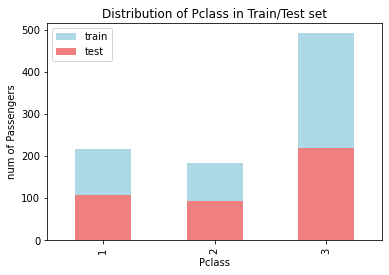

In [85]:
#Pclass : almost same proportion 
train['Pclass'].value_counts().sort_index().plot(kind='bar', color='lightblue', label='train')
test['Pclass'].value_counts().sort_index().plot(kind='bar', color='lightcoral', label='test')

plt.legend()
plt.xlabel('Pclass')
plt.ylabel('num of Passengers')
plt.title('Distribution of Pclass in Train/Test set')

plt.show()

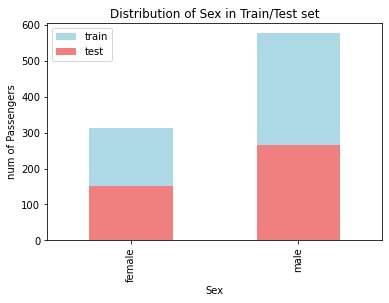

In [86]:
train['Sex'].value_counts().sort_index().plot(kind='bar', color='lightblue', label='train')
test['Sex'].value_counts().sort_index().plot(kind='bar', color='lightcoral', label='test')

plt.legend()
plt.xlabel('Sex')
plt.ylabel('num of Passengers')
plt.title('Distribution of Sex in Train/Test set')

plt.show()

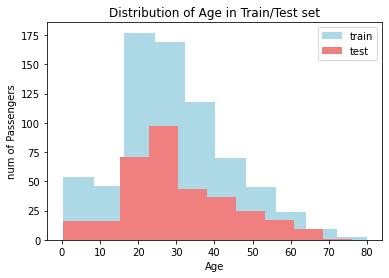

In [87]:
#Age : similar distribution 
train['Age'].plot(kind='hist', color='lightblue', label='train')
test['Age'].plot(kind='hist', color='lightcoral', label='test')

plt.legend()
plt.xlabel('Age')
plt.ylabel('num of Passengers')
plt.title('Distribution of Age in Train/Test set')

plt.show()

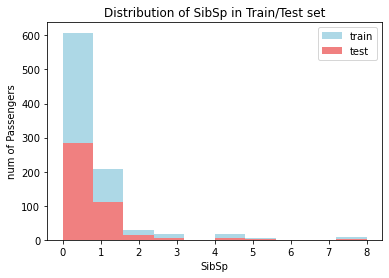

In [88]:
#Sibsp : similar distribution 
train['SibSp'].plot(kind='hist', color='lightblue', label='train')
test['SibSp'].plot(kind='hist', color='lightcoral', label='test')

plt.legend()
plt.xlabel('SibSp')
plt.ylabel('num of Passengers')
plt.title('Distribution of SibSp in Train/Test set')

plt.show()

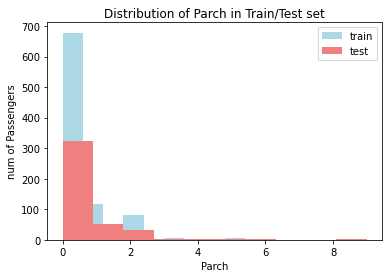

In [89]:
#Parch : similar distribution 
train['Parch'].plot(kind='hist', color='lightblue', label='train')
test['Parch'].plot(kind='hist', color='lightcoral', label='test')

plt.legend()
plt.xlabel('Parch')
plt.ylabel('num of Passengers')
plt.title('Distribution of Parch in Train/Test set')

plt.show()

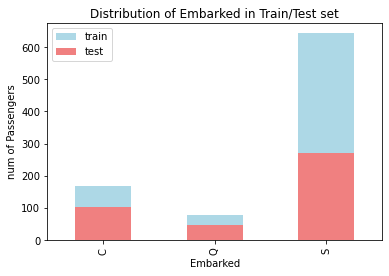

In [90]:
#Embarked : almost same proportion 
train['Embarked'].value_counts().sort_index().plot(kind='bar', color='lightblue', label='train')
test['Embarked'].value_counts().sort_index().plot(kind='bar', color='lightcoral', label='test')

plt.legend()
plt.xlabel('Embarked')
plt.ylabel('num of Passengers')
plt.title('Distribution of Embarked in Train/Test set')

plt.show()

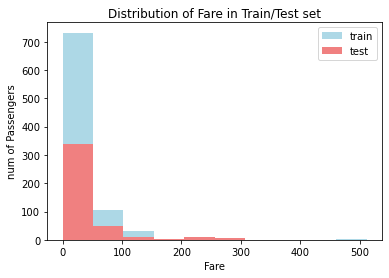

In [91]:
#Fare : similar distribution 
train['Fare'].plot(kind='hist', color='lightblue', label='train')
test['Fare'].plot(kind='hist', color='lightcoral', label='test')

plt.legend()
plt.xlabel('Fare')
plt.ylabel('num of Passengers')
plt.title('Distribution of Fare in Train/Test set')

plt.show()

#Fare= 0인 경우가 존재.... 어떤 경우인지 확인 필요함 


In [92]:
# Cabin .. Cabin has too many values so let it be explored later. 

## Missing Values  
- Age, Cabin 

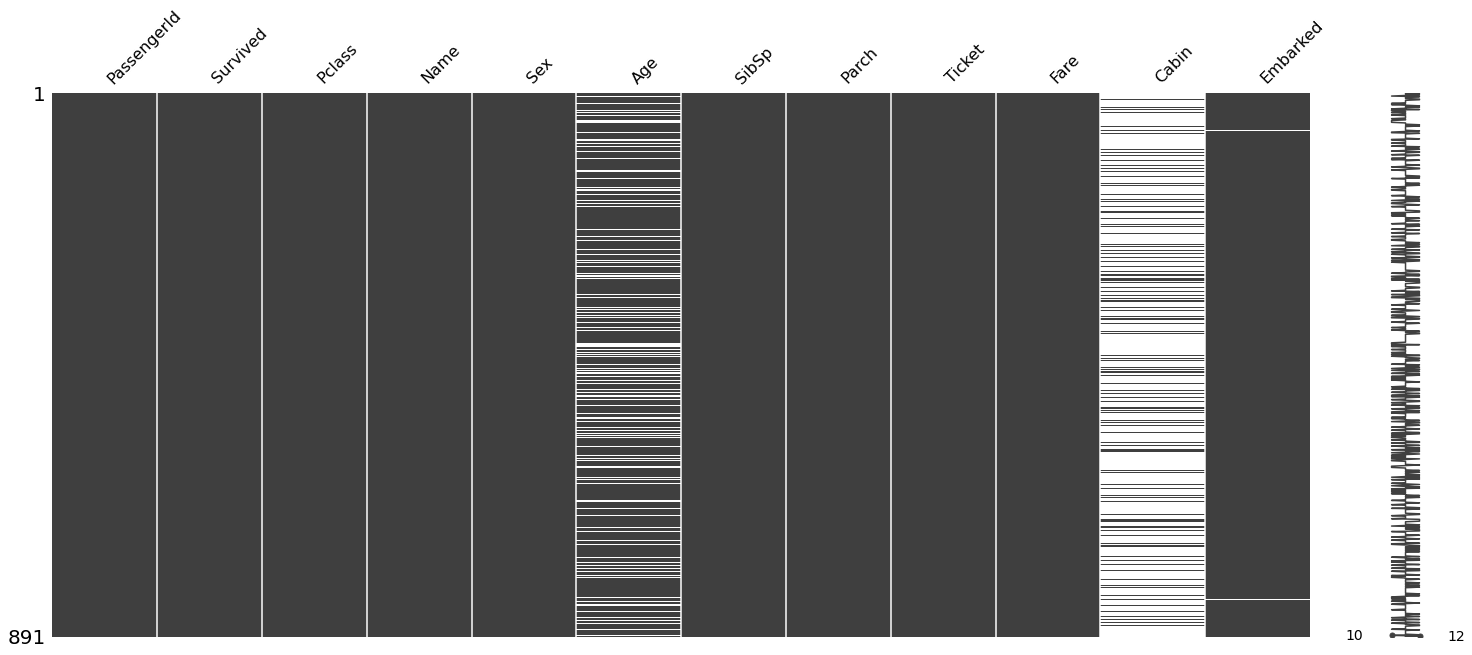

In [93]:
msno.matrix(train)

In [94]:
print('Train Set')
display(train.isnull().sum())
print('='*80)
print('Test Set')
display(test.isnull().sum())

Train Set


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Test Set


PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

### 1. Dealing with missing values in 'Age'
* Age 결측치를 가진 탑승자 정보 확인
* 비슷한 정보를 가진 사람들의 평균 나이 확인하여 결측치 채우기

In [95]:
df_all=pd.concat([train, test])

pd.set_option('display.max_rows', 50)
df_all.Age.fillna(0, inplace=True)
print('Train/Test set - values in [Age]')
df_all.Age.value_counts()

# total 263 missing values 

Train/Test set - values in [Age]


0.00     263
24.00     47
22.00     43
21.00     41
30.00     40
        ... 
22.50      1
74.00      1
24.50      1
80.00      1
0.67       1
Name: Age, Length: 99, dtype: int64

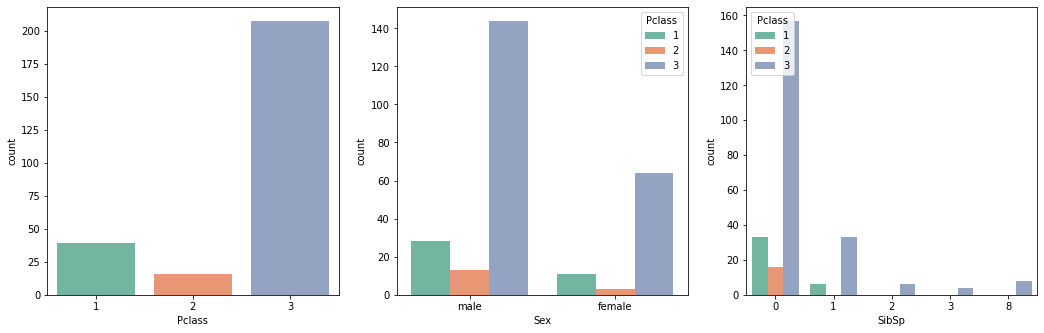

In [96]:
# Dataframe with Missing values of Age 
df_miss_age=df_all[df_all['Age']==0]

fig=plt.figure(figsize=(10,5))

ax1=fig.add_subplot(1,3,1)
ax2=fig.add_subplot(1,3,2)
ax3=fig.add_subplot(1,3,3)
plt.subplots_adjust(left=0.125, bottom=0.1,  right=1.5, top=0.9, wspace=0.2, hspace=0.35)

sns.countplot(x='Pclass', palette='Set2', data=df_miss_age, ax=ax1)
sns.countplot(x='Sex', palette='Set2', data=df_miss_age, ax=ax2, hue='Pclass')
sns.countplot(x='SibSp', palette='Set2', data=df_miss_age, ax=ax3, hue='Pclass')

plt.show()


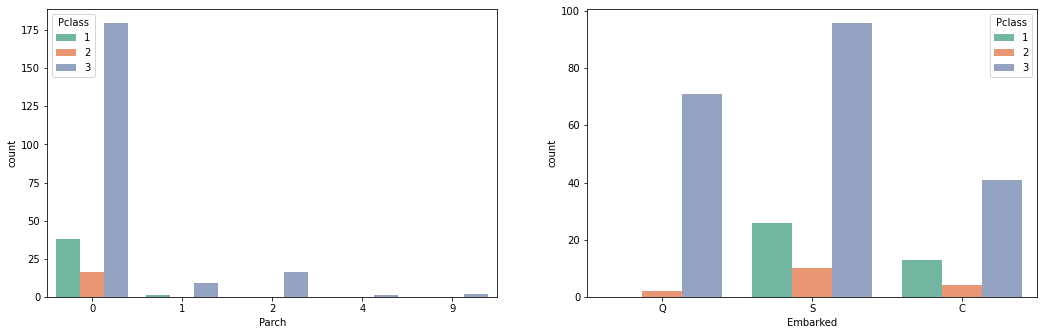

In [97]:
fig=plt.figure(figsize=(10,5))
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)
plt.subplots_adjust(left=0.125, bottom=0.1,  right=1.5, top=0.9, wspace=0.2, hspace=0.35)

sns.countplot(x='Parch', palette='Set2', data=df_miss_age, ax=ax1, hue='Pclass')
sns.countplot(x='Embarked', palette='Set2', data=df_miss_age, ax=ax2, hue='Pclass')

plt.show()

# 나이가 기재되지 않은 승객들은 Pclass에서 두드러진 차이를 보이고 있으므로 나이는 Pclass(+성별?)의 평균? 중앙값?으로 채워주기로 한다. 

In [98]:
display(df_all.groupby(['Sex','Pclass'])['Age'].agg('mean'))
print('='*80)
display(df_all.groupby(['Sex','Pclass'])['Age'].agg('median'))

#평균과 중앙값이 크게 차이나지 않기에 그냥 평균으로 채워주기로 한다.

Sex     Pclass
female  1         34.208333
        2         26.720943
        3         15.611898
male    1         34.611285
        2         28.472690
        3         18.378966
Name: Age, dtype: float64

Sex     Pclass
female  1         35.0
        2         27.0
        3         17.0
male    1         37.0
        2         28.0
        3         21.0
Name: Age, dtype: float64

In [99]:
df_all['Age'] = df_all['Age'].replace(0, np.nan)
df_all['Age']=df_all['Age'].fillna(df_all.groupby(['Sex', 'Pclass'])['Age'].transform('mean'))

### 1.2 Dealing with missing values in 'Cabin'

In [100]:
miss = df_all.Cabin[df_all['Pclass']==1].isnull().sum(axis=0)
notmiss=df_all.Cabin[df_all['Pclass']==1].notnull().sum(axis=0)
print(f'Pclass=1 .. missing values : {miss},  existing values : {notmiss}')
print('='*80)

miss = df_all.Cabin[df_all['Pclass']==2].isnull().sum(axis=0)
notmiss=df_all.Cabin[df_all['Pclass']==2].notnull().sum(axis=0)
print(f'Pclass=2 .. missing values : {miss},  existing values : {notmiss}')
print('='*80)

miss = df_all.Cabin[df_all['Pclass']==3].isnull().sum(axis=0)
notmiss=df_all.Cabin[df_all['Pclass']==3].notnull().sum(axis=0)
print(f'Pclass=3 .. missing values : {miss},  existing values : {notmiss}')

#주로 Pclass=1에서 Cabin values가 존재하는 것으로 보아, Cabin은 Pclass=1의 생존율 예측에 유의미한 영향을 미칠것이라 추론됨  

Pclass=1 .. missing values : 67,  existing values : 256
Pclass=2 .. missing values : 254,  existing values : 23
Pclass=3 .. missing values : 693,  existing values : 16


In [101]:
df_all.Cabin
# Cabin의 알파벳과 숫자를 분리해서 알파벳+n번대로 만들어주고 이를 따로 분리  알파벳 -> [Ca]
# NaN값은 임의의 알파펫 X값으로 분리해줌 

0       NaN
1       C85
2       NaN
3      C123
4       NaN
       ... 
413     NaN
414    C105
415     NaN
416     NaN
417     NaN
Name: Cabin, Length: 1309, dtype: object

In [102]:
df_all['Cabin'].fillna('X', inplace=True)
df_all['Ca']=df_all['Cabin'].str[:1]

### 1.3 filling the missing values - Embarked
There are two missing values on Embared, and referring to the notebook("https://www.kaggle.com/gunesevitan/titanic-advanced-feature-engineering-tutorial), fill the values with 'S'

In [103]:
df_all['Embarked']=df_all['Embarked'].fillna('S')

### 1.4 filling the missing values - Fare

In [104]:
df_all['Fare'].fillna(0, inplace=True)

## Correlation 

In [105]:
df_all.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Ca'],
      dtype='object')

In [106]:
drop_cols = ['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin']
df_all_X=df_all.drop(drop_cols, 1)

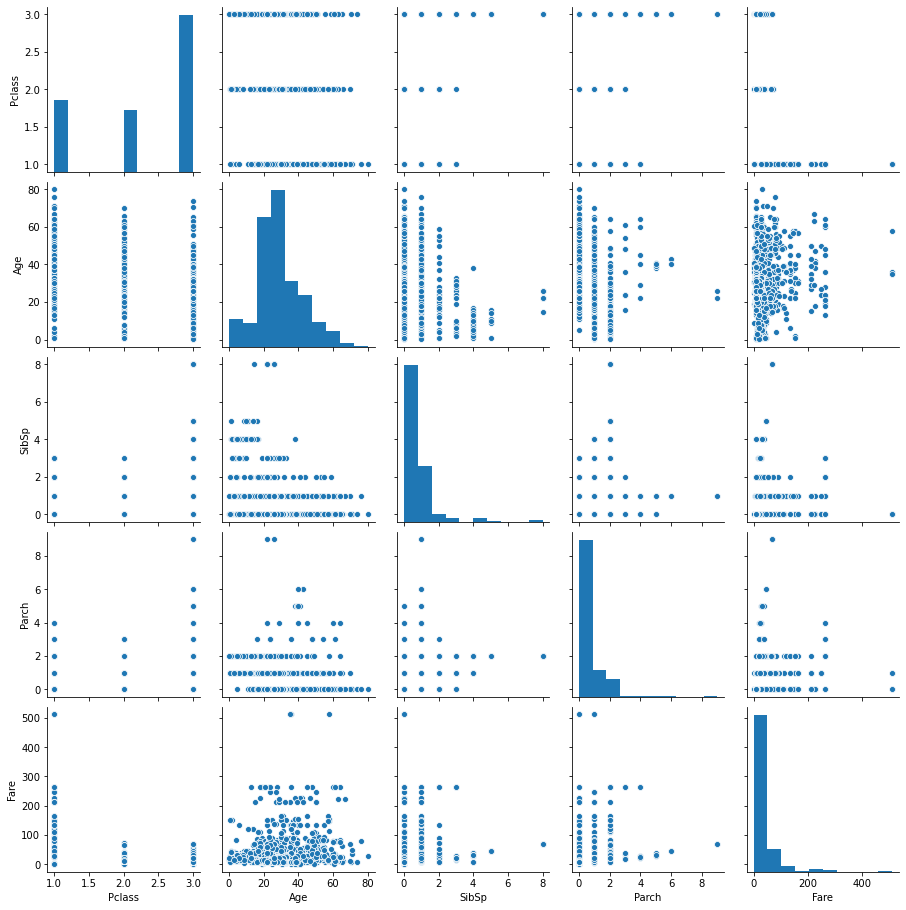

In [107]:
sns.pairplot(df_all_X)

In [108]:
df_all['Fam_size']=df_all['SibSp']+df_all['Parch']
df_all

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ca,Fam_size
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,X,S,X,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C,C,1
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,X,S,X,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S,C,1
4,5,0.0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,X,S,X,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,25.962264,0,0,A.5. 3236,8.0500,X,S,X,0
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.000000,0,0,PC 17758,108.9000,C105,C,C,0
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.500000,0,0,SOTON/O.Q. 3101262,7.2500,X,S,X,0
416,1308,NaN,3,"Ware, Mr. Frederick",male,25.962264,0,0,359309,8.0500,X,S,X,0


In [109]:
df_all['Title'] = df_all['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]

df_all['Marriage'] = 0
df_all['Marriage'].loc[df_all['Title'] == 'Mrs'] = 1

# df_all['Title'].value_counts()

In [110]:
df_all

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ca,Fam_size,Title,Marriage
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,X,S,X,1,Mr,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C,C,1,Mrs,1
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,X,S,X,0,Miss,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S,C,1,Mrs,1
4,5,0.0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,X,S,X,0,Mr,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,25.962264,0,0,A.5. 3236,8.0500,X,S,X,0,Mr,0
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.000000,0,0,PC 17758,108.9000,C105,C,C,0,Dona,0
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.500000,0,0,SOTON/O.Q. 3101262,7.2500,X,S,X,0,Mr,0
416,1308,NaN,3,"Ware, Mr. Frederick",male,25.962264,0,0,359309,8.0500,X,S,X,0,Mr,0


In [111]:
test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


### 4.2 Testing Baseline Models

In [112]:
df_all_train = df_all[df_all.PassengerId <=891]
df_all_test = df_all[df_all.PassengerId>891].drop('Survived', 1)

In [113]:
display(df_all_train.info())
display(df_all_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    float64
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        891 non-null    object 
 11  Embarked     891 non-null    object 
 12  Ca           891 non-null    object 
 13  Fam_size     891 non-null    int64  
 14  Title        891 non-null    object 
 15  Marriage     891 non-null    int64  
dtypes: float64(3), int64(6), object(7)
memory usage: 118.3+ KB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          418 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         418 non-null    float64
 9   Cabin        418 non-null    object 
 10  Embarked     418 non-null    object 
 11  Ca           418 non-null    object 
 12  Fam_size     418 non-null    int64  
 13  Title        418 non-null    object 
 14  Marriage     418 non-null    int64  
dtypes: float64(2), int64(6), object(7)
memory usage: 52.2+ KB


None

In [115]:
# Implement Label Encoding 
cat_cols = ['Sex','Embarked','Ca']

lbl = LabelEncoder()
for col in tqdm_notebook( cat_cols ):   
    temp_df=pd.concat([df_all_train, df_all_test])
    
    lbl.fit( temp_df[col] )
    df_all_train[col]=lbl.transform(df_all_train[col])
    df_all_test[col]=lbl.transform(df_all_test[col])

In [116]:
drop_cols=['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Parch', 'Title']
target_cols=['Survived']

X=df_all_train.drop(drop_cols,1)
y=df_all_train[target_cols]

In [ ]:
X

In [117]:
#1st : RandomForest
from sklearn.model_selection import cross_val_score

rf_model=RandomForestClassifier(
    n_estimators=1000,
    random_state=10,
    class_weight='balanced').fit(X,y)

# KFold 
cv = KFold(n_splits=5, shuffle=True, 
           random_state=11)

cv_scores=cross_val_score(
            rf_model, X, y,
            cv=cv, scoring='accuracy', n_jobs=-1)

print(f'(CV) scores : \n{cv_scores}')
print(f'(CV) scores mean : \n{cv_scores.mean()}')

(CV) scores : 
[0.86592179 0.7752809  0.85393258 0.83146067 0.76966292]
(CV) scores mean : 
0.8192517732722365


In [118]:
# 2nd : DecisionTree 

dt_model=DecisionTreeClassifier(
    random_state=10,
    class_weight='balanced').fit(X,y)
dt_model.score(X,y)

# KFold 

cv = KFold(n_splits=5, shuffle=True, 
           random_state=11)

cv_scores=cross_val_score(
            dt_model,  X, y,
            cv=cv, scoring='accuracy', n_jobs=-1)

print(f'(CV) scores : \n{cv_scores}')
print(f'(CV) scores mean : \n{cv_scores.mean()}')

(CV) scores : 
[0.81005587 0.73595506 0.83146067 0.76404494 0.71910112]
(CV) scores mean : 
0.7721235327349193


In [119]:
# 3rd : xgboost

import xgboost as xgb 
xgb_model=xgb.XGBClassifier(
        n_estimators=1000,
        subsample=0.5,
        reg_alpha=10,
        random_state=1).fit(X, y)

xgb_model.score(X,y)

# KFold 

cv = KFold(n_splits=5, shuffle=True, 
           random_state=11)

cv_scores=cross_val_score(
            xgb_model,   X, y,
            cv=cv, scoring='accuracy', n_jobs=-1)

print(f'(CV) scores : \n{cv_scores}')
print(f'(CV) scores mean : \n{cv_scores.mean()}')

(CV) scores : 
[0.88268156 0.7752809  0.86516854 0.82022472 0.78651685]
(CV) scores mean : 
0.825974515096353


In [120]:
# 4th : KNN 

from sklearn.neighbors import KNeighborsClassifier 

knn_model=KNeighborsClassifier(n_neighbors=5).fit(X,y)
knn_model.score(X,y)

# KFold 

cv = KFold(n_splits=5, shuffle=True, 
           random_state=11)

cv_scores=cross_val_score(
            knn_model,   X, y,
            cv=cv, scoring='accuracy', n_jobs=-1)

print(f'(CV) scores : \n{cv_scores}')
print(f'(CV) scores mean : \n{cv_scores.mean()}')

(CV) scores : 
[0.75977654 0.68539326 0.74719101 0.73595506 0.75280899]
(CV) scores mean : 
0.7362249701839181


In [121]:
#Logistic Regression 

from sklearn.linear_model import LogisticRegression
lr_model=LogisticRegression(
    C=0.01, max_iter=1000).fit(X,y)

lr_model.score(X,y)

# KFold 

cv = KFold(n_splits=5, shuffle=True, 
           random_state=11)

cv_scores=cross_val_score(
            lr_model,   X, y,
            cv=cv, scoring='accuracy', n_jobs=-1)

print(f'(CV) scores : \n{cv_scores}')
print(f'(CV) scores mean : \n{cv_scores.mean()}')

(CV) scores : 
[0.81564246 0.7247191  0.75280899 0.76404494 0.69662921]
(CV) scores mean : 
0.750768941058314


In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy'],
    'class_weight' : ['balanced']
}

cv = KFold(n_splits=5, shuffle=True, 
           random_state=10)

base_model=RandomForestClassifier(
    random_state=10).fit(X,y)

grid_model = GridSearchCV(
                base_model,
                param_grid=param_grid)

grid_model.fit(X, y)

print(f'best_score : {grid_model.best_score_}')
print(f'best_params : \n{grid_model.best_params_}')


In [123]:
# fitting model

rf_new_model = RandomForestClassifier(class_weight= 'balanced', 
                                      criterion= 'gini',
                                      max_depth= 6, 
                                      max_features= 'log2',
                                      n_estimators= 200).fit(X, y)
score = rf_new_model.score(X, y)
print(f'(MODEL) TRAIN SCORE : {score}')

(MODEL) TRAIN SCORE : 0.8754208754208754


## [4] test data import, preprocessing

In [ ]:
# df_test = pd.read_csv("../input/titanic/test.csv")
# df_test.set_index('PassengerId', inplace=True)
# msno.matrix(df_test)
df_all_test.head(3)

In [124]:
drop_cols=['PassengerId','Name', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Title']
X_test = df_all_test.drop(drop_cols,1)

In [ ]:
X_test

In [125]:
y_preds = rf_new_model.predict(X_test).astype(int)

In [129]:
submission = pd.DataFrame({'PassengerId':df_all_test.PassengerId, 
              'Survived':y_preds})
submission.to_csv('submission2-1.csv', index=False)
sub=pd.read_csv('submission2-1.csv')

In [130]:
sub.head(20)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,0
7,899,0
8,900,1
9,901,0
